## **Loading the raw dataset**

In [38]:
import pandas as pd
import csv

df = pd.read_parquet("/content/drive/MyDrive/mml/mml_dataset.parquet",engine="pyarrow")

In [39]:
df.shape

(294888, 6)

In [40]:
df = df.drop('column0',axis=1)

**Data Cleaning by removing the duplicates tokenizing and find the most relevent words and stuff**

In [41]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
import string
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
def deduplicate_and_tokenize(df):
    df = df.drop_duplicates(subset='Label_ID', keep='first')

    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)
    df['tokenized_title'] = df['Title'].apply(lambda text: tokenizer.tokenize(text) if isinstance(text, str) else [])
    df['tokenized_body'] = df['Body'].apply(lambda text: tokenizer.tokenize(text) if isinstance(text, str) else [])
    df['tokenized_subreddit'] = df['Subreddit'].apply(lambda text: tokenizer.tokenize(text) if isinstance(text, str) else [])

    df['processed_title'] = df['tokenized_title'].apply(preprocess)
    df['processed_body'] = df['tokenized_body'].apply(preprocess)

    return df

In [43]:
def preprocess(tokens, ignore_urls=True, ignore_hashtags=True, ignore_mentions=True, ignore_numbers=True, remove_stopwords=True, ignore_punctuation=True, min_length=1):
    cleaned_tokens = []
    num_of_hashtags = 0
    punctuations = list(string.punctuation)
    sword = stopwords.words('english')

    for token in tokens:
        if remove_stopwords and token in sword:
            continue
        if ignore_urls and (token.startswith('https:') or token.startswith('http:')):
            continue
        if ignore_hashtags and token.startswith('#'):
            token = token.replace('#', '')
            num_of_hashtags += 1
        if ignore_mentions and token.startswith('@'):
            continue
        if ignore_numbers and token.isnumeric():
            continue
        if ignore_punctuation and token in punctuations:
            continue

        cleaned_tokens.append(token)

    if (len(cleaned_tokens) < min_length) or ((len(cleaned_tokens) - num_of_hashtags) < min_length):
        return np.nan
    else:
        return cleaned_tokens

In [44]:
posts = deduplicate_and_tokenize(df)

<ipython-input-42-840db7265e0f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_title'] = df['Title'].apply(lambda text: tokenizer.tokenize(text) if isinstance(text, str) else [])
<ipython-input-42-840db7265e0f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized_body'] = df['Body'].apply(lambda text: tokenizer.tokenize(text) if isinstance(text, str) else [])
<ipython-input-42-840db7265e0f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [45]:
# Reindex the DataFrame
posts = posts.reset_index(drop=True)
posts.shape

(58811, 10)

In [47]:
# Initialize an empty list to store words
words = []

# Iterate over the tokenized_title and tokenized_body columns
for index, row in posts.iterrows():
    words.extend(row['tokenized_title'])
    words.extend(row['tokenized_body'])

# Print the first few words to check the result
print(words[:50])

['weekly', 'survey', 'and', 'studies', 'thread', 'please', 'use', 'this', 'thread', 'to', 'post', 'any', 'surveys', 'and', 'studies', 'you', 'are', 'looking', 'for', 'volunteers', 'for', '.', 'please', 'include', 'links', 'and', 'details', 'for', 'whatever', 'you', 'want', 'people', 'to', 'know', '.', 'please', 'note', ',', 'any', 'survey', 'and', '/', 'or', 'study', 'requests', 'posted', 'outside', 'of', 'this', 'weekly']


In [48]:
words_df = pd.DataFrame(words)
words_df['words'] = words_df
words_df = pd.DataFrame(words_df['words'])
words_df.head()

,words
0,weekly
1,survey
2,and
3,studies
4,thread


In [49]:
new_df = words_df.groupby(['words'])
count_df= new_df['words'].count()

count_df = pd.DataFrame(count_df)
count_df.rename(columns={"words":"Count"}, inplace=True)
count_df = count_df.reset_index()
count_df = count_df.sort_values("Count", ascending=False)

In [50]:
count_df.head(50)

,words,Count
2076,.,489139
2029,",",397360
69279,i,349083
13522,and,337124
117248,to,326830
115999,the,301601
10265,a,218950
89168,of,187354
1983,*,141986
70305,in,139197


In [51]:
from collections import Counter

# Drop rows with missing values in 'tokenized_title' and 'tokenized_body' columns
posts.dropna(subset=['processed_title', 'processed_body'], inplace=True)

# Concatenate tokenized arrays from 'tokenized_title' and 'tokenized_body' columns
all_tokens = posts['processed_title'] + posts['processed_body']

# Flatten the concatenated array
all_tokens_flat = [word for sublist in all_tokens if isinstance(sublist, list) for word in sublist]

# Count the occurrences of each word
word_counts = Counter(all_tokens_flat)

# Get the top 50 most common words
top_50_words = [word for word, _ in word_counts.most_common(50)]

# Function to remove top 50 words from a list of tokens
def remove_top_50(tokens):
    return [token for token in tokens if token not in top_50_words]

# Apply remove_top_50 function to all tokens
filtered_tokens = [remove_top_50(tokens) for tokens in all_tokens]

# Assign the filtered tokens to the 'combined' column
posts['combined'] = filtered_tokens


In [52]:
posts.head()

,Title,Num_Comments,Body,Subreddit,Label_ID,tokenized_title,tokenized_body,tokenized_subreddit,processed_title,processed_body,combined
0,Weekly Survey and Studies Thread,9,Please use this thread to post any surveys and...,Anxietyhelp,9d45cb1337e653bf8039a9ff211d6c0f85451bfb90a845...,"[weekly, survey, and, studies, thread]","[please, use, this, thread, to, post, any, sur...",[anxietyhelp],"[weekly, survey, studies, thread]","[please, use, thread, post, surveys, studies, ...","[weekly, survey, studies, thread, please, use,..."
1,Morning Anxiety,6,I've been going through A LOT over the past se...,Anxietyhelp,028f3eab7640783f8bd39d9b170b5f91bee5d985fdcf79...,"[morning, anxiety]","[i've, been, going, through, a, lot, over, the...",[anxietyhelp],"[morning, anxiety]","[i've, going, lot, past, several, months, abso...","[morning, anxiety, lot, past, several, months,..."
2,does anyone know how to help??,7,"&#x200B;\n\nwell, to make things short, ive ne...",Anxietyhelp,ce87c41718da8ea4823052e02cb4dd4fbd901a0f788efc...,"[does, anyone, know, how, to, help, ?, ?]","[​, well, ,, to, make, things, short, ,, ive, ...",[anxietyhelp],"[anyone, know, help]","[​, well, make, things, short, ive, never, sch...","[​, well, short, ive, school, trips, cinemas, ..."
3,24F and no friends,10,I don't know how to make friends and to this p...,Anxietyhelp,da1bc059a46da018df5c80806173e49d5aeb5cf383fe08...,"[24f, and, no, friends]","[i, don't, know, how, to, make, friends, and, ...",[anxietyhelp],"[24f, friends]","[know, make, friends, point, embarrassing, ......","[24f, friends, friends, point, embarrassing, ...."
4,🤷🏻‍♀️,1,Do any of you ever just feel like your heart i...,Anxietyhelp,c4fce8b0f4210a726f980ac015363aa46fe3ab39a65b0b...,"[🤷🏻‍♀, ️]","[do, any, of, you, ever, just, feel, like, you...",[anxietyhelp],"[🤷🏻‍♀, ️]","[ever, feel, like, heart, going, snap, stressi...","[🤷🏻‍♀, ️, ever, heart, snap, stressing, doctor..."


In [54]:
# Create a copy of Label_ID column and rename it to ID
posts['ID'] = posts['Label_ID'].copy()
posts.head()

,Title,Num_Comments,Body,Subreddit,tokenized_title,tokenized_body,tokenized_subreddit,processed_title,processed_body,combined,ID
0,Weekly Survey and Studies Thread,9,Please use this thread to post any surveys and...,Anxietyhelp,"[weekly, survey, and, studies, thread]","[please, use, this, thread, to, post, any, sur...",[anxietyhelp],"[weekly, survey, studies, thread]","[please, use, thread, post, surveys, studies, ...","[weekly, survey, studies, thread, please, use,...",9d45cb1337e653bf8039a9ff211d6c0f85451bfb90a845...
1,Morning Anxiety,6,I've been going through A LOT over the past se...,Anxietyhelp,"[morning, anxiety]","[i've, been, going, through, a, lot, over, the...",[anxietyhelp],"[morning, anxiety]","[i've, going, lot, past, several, months, abso...","[morning, anxiety, lot, past, several, months,...",028f3eab7640783f8bd39d9b170b5f91bee5d985fdcf79...
2,does anyone know how to help??,7,"&#x200B;\n\nwell, to make things short, ive ne...",Anxietyhelp,"[does, anyone, know, how, to, help, ?, ?]","[​, well, ,, to, make, things, short, ,, ive, ...",[anxietyhelp],"[anyone, know, help]","[​, well, make, things, short, ive, never, sch...","[​, well, short, ive, school, trips, cinemas, ...",ce87c41718da8ea4823052e02cb4dd4fbd901a0f788efc...
3,24F and no friends,10,I don't know how to make friends and to this p...,Anxietyhelp,"[24f, and, no, friends]","[i, don't, know, how, to, make, friends, and, ...",[anxietyhelp],"[24f, friends]","[know, make, friends, point, embarrassing, ......","[24f, friends, friends, point, embarrassing, ....",da1bc059a46da018df5c80806173e49d5aeb5cf383fe08...
4,🤷🏻‍♀️,1,Do any of you ever just feel like your heart i...,Anxietyhelp,"[🤷🏻‍♀, ️]","[do, any, of, you, ever, just, feel, like, you...",[anxietyhelp],"[🤷🏻‍♀, ️]","[ever, feel, like, heart, going, snap, stressi...","[🤷🏻‍♀, ️, ever, heart, snap, stressing, doctor...",c4fce8b0f4210a726f980ac015363aa46fe3ab39a65b0b...


In [55]:
# Drop specified columns
columns_to_drop = ['tokenized_title', 'tokenized_body', 'tokenized_subreddit', 'processed_title', 'processed_body']
posts.drop(columns=columns_to_drop, inplace=True)

# Reindex the DataFrame
posts.reset_index(drop=True, inplace=True)

In [56]:
posts.head()

,Title,Num_Comments,Body,Subreddit,combined,ID
0,Weekly Survey and Studies Thread,9,Please use this thread to post any surveys and...,Anxietyhelp,"[weekly, survey, studies, thread, please, use,...",9d45cb1337e653bf8039a9ff211d6c0f85451bfb90a845...
1,Morning Anxiety,6,I've been going through A LOT over the past se...,Anxietyhelp,"[morning, anxiety, lot, past, several, months,...",028f3eab7640783f8bd39d9b170b5f91bee5d985fdcf79...
2,does anyone know how to help??,7,"&#x200B;\n\nwell, to make things short, ive ne...",Anxietyhelp,"[​, well, short, ive, school, trips, cinemas, ...",ce87c41718da8ea4823052e02cb4dd4fbd901a0f788efc...
3,24F and no friends,10,I don't know how to make friends and to this p...,Anxietyhelp,"[24f, friends, friends, point, embarrassing, ....",da1bc059a46da018df5c80806173e49d5aeb5cf383fe08...
4,🤷🏻‍♀️,1,Do any of you ever just feel like your heart i...,Anxietyhelp,"[🤷🏻‍♀, ️, ever, heart, snap, stressing, doctor...",c4fce8b0f4210a726f980ac015363aa46fe3ab39a65b0b...


In [57]:
posts.shape

(39061, 6)

In [59]:
from wordcloud import WordCloud
words = words[50:]
wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(words))

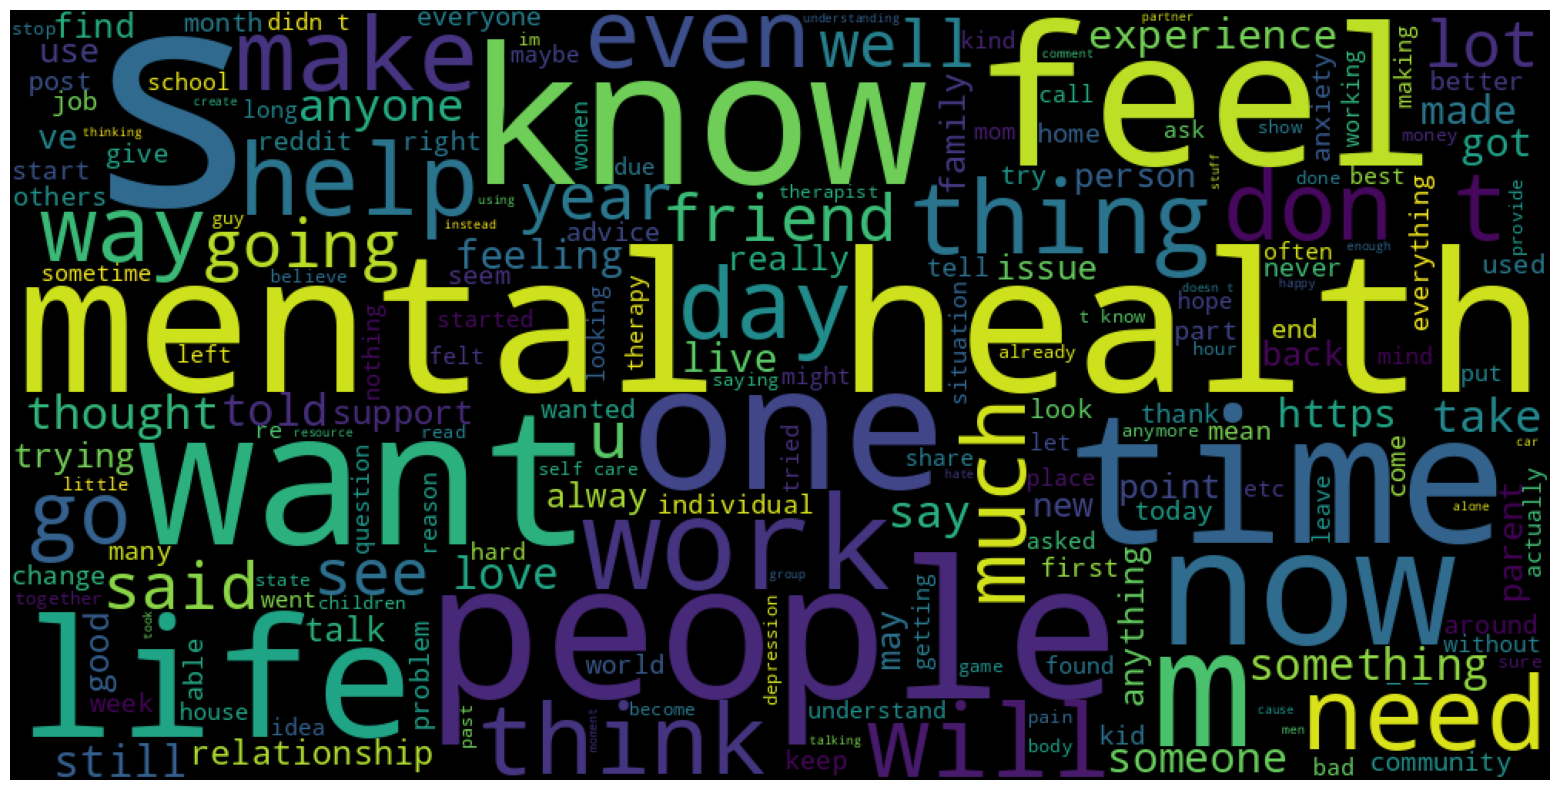

In [60]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,10))

plt.imshow(wordcloud)
plt.axis("off")
fig.savefig("sad.png")
plt.show()
plt.close()

In [58]:
posts.to_csv("mml_cleaned.csv",index = False)